# Supplementary code for "An application of Bayesian inference to epidemic modeling"

**João Pedro Valeriano Miranda - IFT-Unesp**

**Pedro Henrique Pinheiro Cintra - IFGW-Unicamp**

## Packages

In [1]:
print("Pakages' versions:")
print("------------------")
!pip list | grep -E numpy\|scipy\|pandas\|numba\|matplotlib\|seaborn\|tqdm

Pakages' versions:
------------------
matplotlib           3.5.1
matplotlib-inline    0.1.3
numba                0.55.0
numpy                1.21.5
pandas               1.3.5
scipy                1.7.3
seaborn              0.11.2
tqdm                 4.62.3


In [2]:
# import necessary packages
import numpy as np # arrays etc
import pandas as pd # csv data handling
from scipy.optimize import curve_fit # curve fitting
from scipy.stats import norm, lognorm # distributions
from scipy.stats import spearmanr # spearman correlation calculation
import matplotlib.pyplot as plt # plotting
import seaborn as sns # also plotting
from numba import njit # function pre-compilation for performance
from tqdm import tqdm # progress bar display

## Quick exploratory analysis

Let's quickly import the data and look at it.

In [3]:
data = pd.read_csv("dados_trabalho.csv") # read data

In [4]:
# save time and number of infected to arrays
t = np.array(data["t"])
I = np.array(data["I(t)"])

In [5]:
# latex for text in plots
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

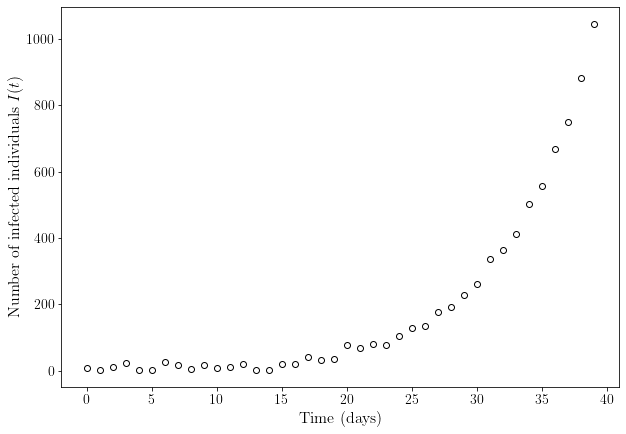

In [6]:
# plotting the data
plt.figure(figsize=(10,7))
plt.scatter(t, I, facecolors="w", edgecolors="k")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Time (days)", fontsize=16)
plt.ylabel("Number of infected individuals $I(t)$", fontsize=16)
# plt.show()
plt.savefig("infected_data.png", dpi=300, bbox_inches="tight")

We can directly fit this with a simple exponential growth via least squares to have an idea of what to expect.

In [7]:
# exponential function with parameter theta and initial condition fixed at data value I[0]
@njit
def exp_func(t, theta):
    # t: vector with time points
    # theta: parameter, growth rate
    
    return I[0]*np.exp(theta*t)

Estimated optimal theta: [0.1193198]
Estimated variance of theta: [[3.03056192e-07]]


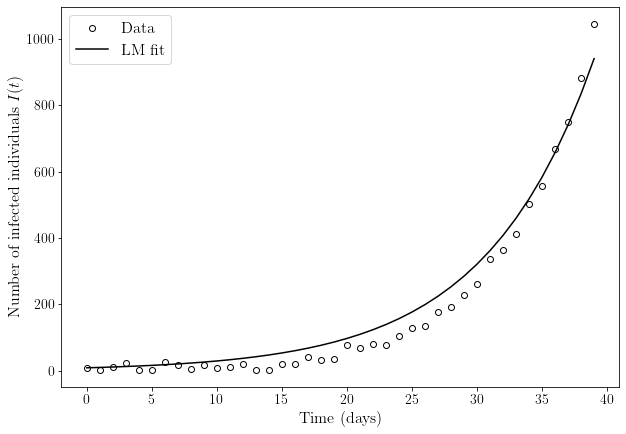

In [8]:
p = curve_fit(exp_func, t, I, method="lm") # fit model to data
print(f"Estimated optimal theta: {p[0]}")
print(f"Estimated variance of theta: {p[1]}")

theta_opt = p[0]

# plot comparison between data and model
plt.figure(figsize=(10,7))
plt.scatter(t, I, facecolors="w", edgecolors="k", label="Data")
plt.plot(t, exp_func(t, p[0][0]), c="k", label="LM fit")
plt.legend(loc="upper left", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Time (days)", fontsize=16)
plt.ylabel("Number of infected individuals $I(t)$", fontsize=16)
# plt.show()
plt.savefig("infected_with_fit.png", dpi=300, bbox_inches="tight")

## Bayesian inference

In [9]:
@njit
def post_pdf(params, t, I): # posterior distribution pdf, derived from likelihood and priors
    # params: list with theta and sigma params
    # t: vector with time points
    # I: vector with infected number data
    
    theta, sigma = params
    if 0.1 <= theta <= 0.2 and 10 <= sigma <= 15:
        return np.exp(-np.sum((I-exp_func(t, theta))**2)/(2*sigma**2))/0.1/5
    else:
        return 0.
    
@njit
def log_post_pdf(params, t, I): # logarithm of posterior pdf
    # params: list with theta and sigma params
    # t: vector with time points
    # I: vector with infected number data
    
    theta, sigma = params
    if 0.1 <= theta <= 0.2 and 10 <= sigma <= 15:
        return -np.sum((I-exp_func(t, theta))**2)/(2*sigma**2)-np.log(0.5)
    else:
        return -np.inf

In [10]:
# diagnosis of metropolis algorithm
def metropolis_diag(t, I, n_samples, dtheta, dsigma):    
    # t: vector with time points
    # I: vector with infected number data
    # n_samples: number of samples to generate
    # burnin: number of burn-in samples to be discarded before starting to collect
    # dtheta, dsigma: standard deviations for next sample candidate generation
    
    # initial values for theta and sigma
    theta0 = 0.15
    sigma0 = 12.5
    
    d = np.array([dtheta, dsigma]) # array with standard deviations for next sample generation
    s = np.array([[theta0, sigma0]]) # array with actual sample for next sample generation
    
    samples = np.copy(s) # initialize sample list

    for i in range(n_samples):
        s1 = np.array([[np.random.normal(s[0,i], d[i]) for i in range(len(s[0]))]]) # generate candidade sample
        
        p = log_post_pdf(s[0], t, I) # calculate log of posterior PDF at last sample
        p1 = log_post_pdf(s1[0], t, I) # calculate log of posterior PDF at the candidate sample
        
        if p > -np.inf and p1 > -np.inf: # check if both have non-zero probability
            r = p1-p # log of ratio between probabilities -> difference of logs of probabilities
            
            if r > 0: # if candidate sample has higher probability than last sample
                s = s1 # accept candidate sample
                samples = np.concatenate((samples, s)) # save sample

            elif np.log(np.random.random()) < r: # if candidate has lower probability if can still be accepted at random
                s = s1 # accept candidate sample
                samples = np.concatenate((samples, s)) # save sample
        
    return samples

In [11]:
# create grid to diagnose the metropolis algorithm for the given problem
deltas = 10**np.linspace(-3, -1, 3)
deltas

array([0.001, 0.01 , 0.1  ])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.59s/it]


delta_theta = 0.001 done


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.03s/it]


delta_theta = 0.01 done


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.79s/it]


delta_theta = 0.1 done


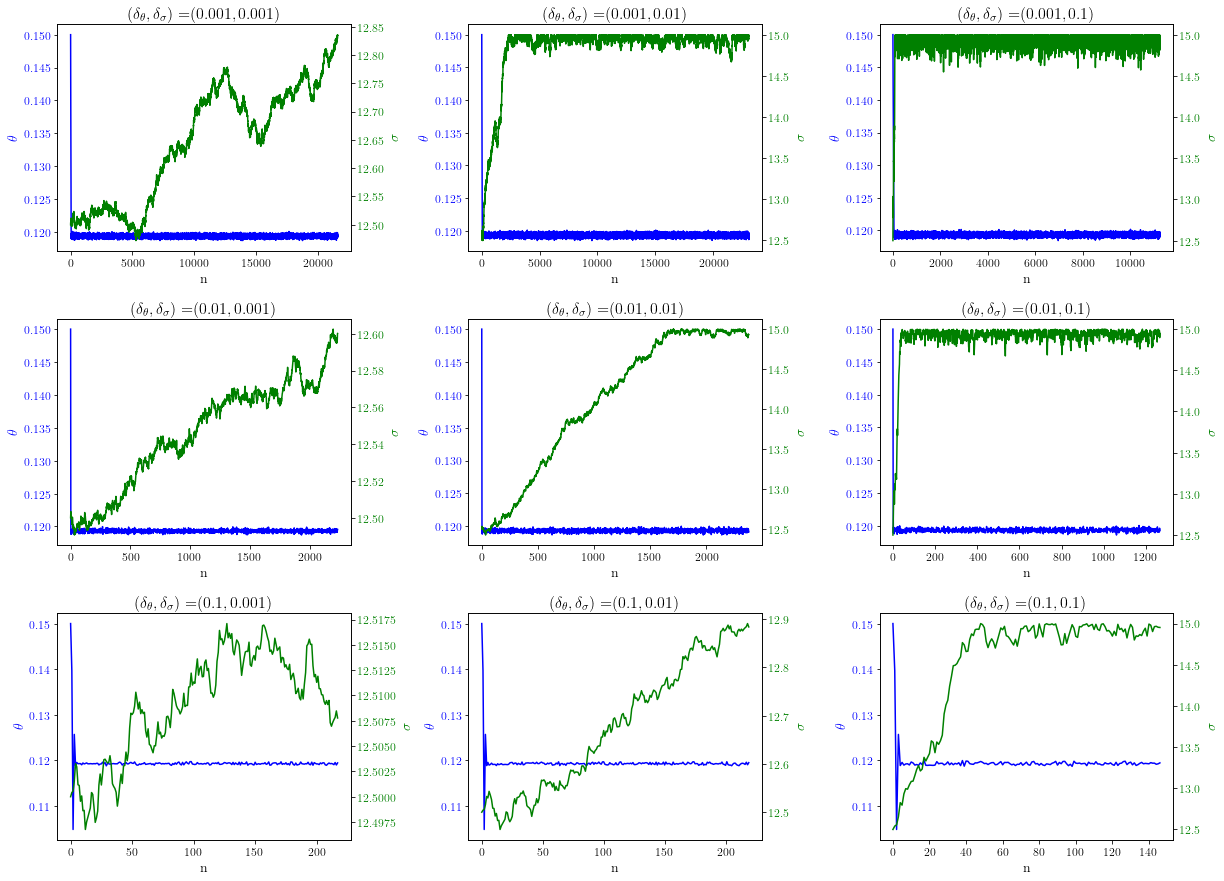

In [12]:
n_samples = int(1e5)

plt.subplots(len(deltas), len(deltas), figsize=(20,15))
plt.subplots_adjust(wspace=0.4, hspace=0.3)

for i in range(len(deltas)):
    for j in tqdm(range(len(deltas))):
        np.random.seed(0)
        samples = metropolis_diag(t, I, n_samples, deltas[i], deltas[j])
        
        plt.subplot(len(deltas),len(deltas),i*len(deltas)+j+1)
        plt.plot(samples[:,0], c="b")
        plt.xlabel("n", fontsize=14)
        plt.xticks(fontsize=12)
        plt.ylabel(r"$\theta$", fontsize=14, color="b")
        plt.yticks(color="b", fontsize=12)
        axr = plt.gca().twinx()
        axr.plot(samples[:,1], c="green")
        plt.ylabel(r"$\sigma$", fontsize=14, color="green")
        plt.yticks(color="green", fontsize=12)
        plt.title(r"$(\delta_{\theta},\delta_{\sigma})=$"+f"$({deltas[i]},{deltas[j]})$", fontsize=16)
    
    print(f"delta_theta = {deltas[i]} done")
    
# plt.show()
plt.savefig("mcmc_diagnostic_dtheta_dsigma.png", dpi=500, bbox_inches="tight")

From the results, we see the pair $(\delta_{\theta},\delta_{\sigma}) = (0.001, 0.01)$ results in the highest number of accepted samples, while taking just a little longer than the cases $(\delta_{\theta},\delta_{\sigma}) = (0.001, 0.1)$ or $(0.01, 0.1)$, but this can be solved by discarding an initial set of samples, the so called burn-in. From the plot, we can see that discarding the first 5000 samples would be more than enough to reach convergence of the algorithm

In [13]:
# metropolis-hastings sampling algorithm
def metropolis(t, I, n_samples, burnin, dtheta, dsigma):
    # t: vector with time points
    # I: vector with infected number data
    # n_samples: number of samples to generate
    # burnin: number of burn-in samples to be discarded before starting to collect
    # dtheta, dsigma: standard deviations for next sample candidate generation
    
    # initial values for theta and sigma
    theta0 = 0.1
    sigma0 = 10.
    
    d = np.array([dtheta, dsigma]) # array with standard deviations for next sample generation
    s = np.array([[theta0, sigma0]]) # array with actual sample for next sample generation
    
    samples = np.copy(s) # initialize sample list
    p_max = -np.inf # initialize MAP
    
    burn_count = 0
    
    while burn_count < burnin:
        s1 = np.array([[np.random.normal(s[0,i], d[i]) for i in range(len(s[0]))]]) # generate candidade sample
        # s1 = np.random.normal(s[0], d, (1,2)) # generate candidade sample
        
        p = log_post_pdf(s[0], t, I) # calculate log of posterior PDF at last sample
        p1 = log_post_pdf(s1[0], t, I) # calculate log of posterior PDF at the candidate sample
        
        if p > -np.inf and p1 > -np.inf: # check if both have non-zero probability
            r = p1-p # log of ratio between probabilities -> difference of logs of probabilities
            
            if r > 0: # if candidate sample has higher probability than last sample
                s = s1 # accept candidate sample
                burn_count += 1
                
            elif np.log(np.random.random()) < r: # if candidate has lower probability if can still be accepted at random
                s = s1 # accept candidate sample
                burn_count += 1
            
            # else: the sample stays the same
    
    while len(samples) < n_samples:
        s1 = np.array([[np.random.normal(s[0,i], d[i]) for i in range(len(s[0]))]]) # generate candidade sample
        # s1 = np.random.normal(s[0], d, (1,2)) # generate candidade sample
        
        p = log_post_pdf(s[0], t, I) # calculate log of posterior PDF at last sample
        p1 = log_post_pdf(s1[0], t, I) # calculate log of posterior PDF at the candidate sample
        
        if p > -np.inf and p1 > -np.inf: # check if both have non-zero probability
            r = p1-p # log of ratio between probabilities -> difference of logs of probabilities
            
            if r > 0: # if candidate sample has higher probability than last sample
                s = s1 # accept candidate sample
                if p1 > p_max: # MAP update
                    p_max = p1
                    s_max = s
                samples = np.concatenate((samples, s)) # save sample
                
            elif np.log(np.random.random()) < r: # if candidate has lower probability if can still be accepted at random
                s = s1 # accept candidate sample
                samples = np.concatenate((samples, s)) # save sample
        
    return samples[1:], s_max # discard first sample as it was used only for array initialization (numba requires a first array item to determine its type)

In [14]:
n_samples = int(1e4)
burnin = int(5e3)

np.random.seed(0)
dist, s_max = metropolis(t, I, n_samples, burnin, 0.001, 0.01)
s_max = s_max[0]

<Figure size 720x576 with 0 Axes>

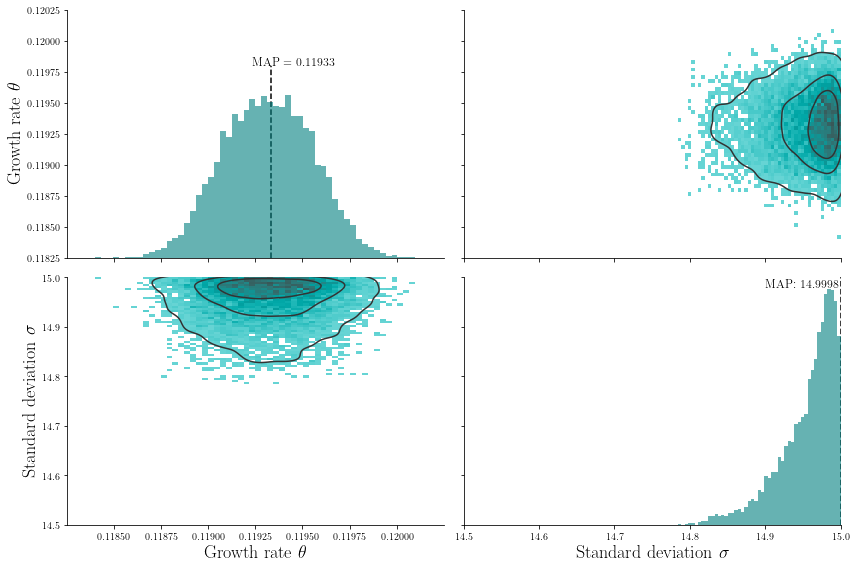

In [15]:
fig = plt.figure(figsize=(10,8))
g = sns.pairplot(data=pd.DataFrame(data=dist), kind="hist", height=4, aspect=1.5,
                 plot_kws= {'color': 'teal'}, diag_kws={'color': 'teal', 'alpha': 0.6,
                                                       'linewidth': 0})
g.map_lower(sns.kdeplot, levels=4, color=".2")
g.map_upper(sns.kdeplot, levels=4, color=".2")
g.axes[0,0].set_ylabel(r'Growth rate $\theta$', fontsize = 18)
g.axes[0,0].vlines(s_max[0], 0.11825, 0.1198, linestyles = 'dashed', color = 'black')
g.axes[0,0].text(1.001*s_max[0], 0.11980, f'MAP = {s_max[0]:.5f}', fontsize = 12, ha = 'center')
g.axes[0,0].set_ylim(0.11825, 0.12025)
g.axes[1,0].set_ylabel('Standard deviation $\sigma$', fontsize = 18)
g.axes[1,0].set_xlabel(r'Growth rate $\theta$', fontsize = 18)
g.axes[1,0].set_ylim(14.5, 15)
g.axes[1,1].set_xlabel('Standard deviation $\sigma$', fontsize = 18)
g.axes[1,1].text(14.9, 14.98, f'MAP: {s_max[1]:.4f}', fontsize = 12)
g.axes[1,1].set_xlim(14.5, 15)
g.axes[1,1].vlines(s_max[1], 14.5, 15, linestyles = 'dashed', color = 'black')

plt.tight_layout()
fig.patch.set_alpha(0)
for ax in fig.axes:
    ax.patch.set_alpha(0)
plt.savefig('pairplot.png', dpi = 300, bbox_inches = 'tight')

From the plots, there doesn't seem to be a strong correlation between $\theta$ and $\sigma$. Calculating the Spearman correlation coefficient between parameters we can confirm that is the case indeed.

In [16]:
spearmanr(*dist.T) # spearman correlation coefficient

SpearmanrResult(correlation=0.024742282209817296, pvalue=0.013354466546477813)

## Setting the initial condition free

We now set $I_{0}$ to also be a free parameter to be fit, so that we can check how it may affect the capability of the model to describe the observed data.

In [17]:
# exponential function with free parameters theta and I_0
@njit
def exp_func2(t, I0, theta):
    # t: vector with time points
    # theta: parameter, growth rate
    
    return I0*np.exp(theta*t)

p = curve_fit(exp_func2, t, I, method="lm") # fit model to data
print(f"Estimated optimal parameters (I0 and theta): {p[0]}")
print(f"Estimated covariance matrix:\n{p[1]}")

Estimated optimal parameters (I0 and theta): [2.8624989  0.15103572]
Estimated covariance matrix:
[[ 3.05372144e-02 -2.92557835e-04]
 [-2.92557835e-04  2.82610111e-06]]


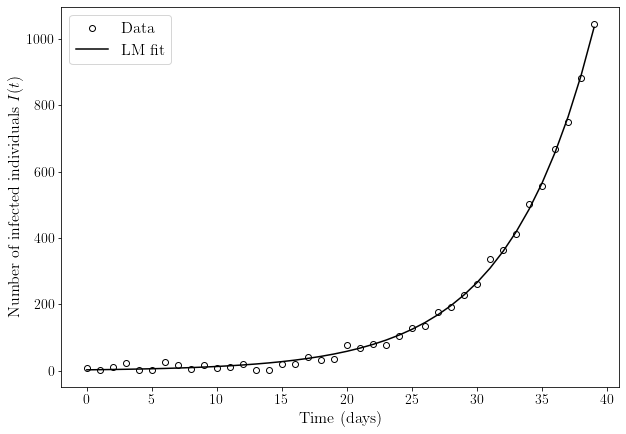

In [18]:
plt.figure(figsize=(10,7))
plt.scatter(t, I, facecolors="w", edgecolors="k", label="Data")
plt.plot(t, exp_func2(t, *p[0]), c="k", label="LM fit")
plt.legend(loc="upper left", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Time (days)", fontsize=16)
plt.ylabel("Number of infected individuals $I(t)$", fontsize=16)
# plt.show()
plt.savefig("infected_fit_I0.png", dpi=300, bbox_inches="tight")

For doing the inference of $I_{0}$, we need to give it a prior distribution. As this variable can only be positive, we choose it to have a lognormal prior distribution, with mode on the data value $y_{0} = y(t=0)$. The log-normal PDF is given by: $$ f(x) = \frac{1}{x\sigma\sqrt{2\pi}}\exp\left[-\frac{\left(\ln(x)-\mu\right)^{2}}{2\sigma^{2}}\right]. $$

The mode of the PDF is given by $\exp(\mu-\sigma^{2})$, and the $\sigma$ parameter of the PDF is set to 5% of the value of $I_{0}$. Here we can visualize the distribution:

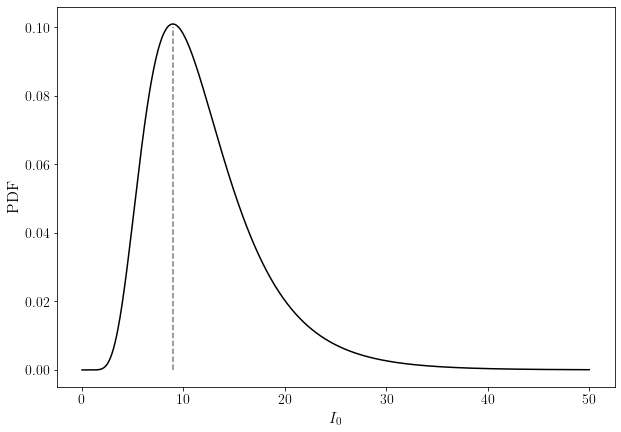

In [19]:
std = I[0]/20 # log-normal PDF's sigma parameter
mu = np.log(I[0])+std**2 # average
x = np.linspace(0.01, 50, 1000) # domain for plotting the PDF

# plotting
plt.figure(figsize=(10,7))
plt.plot(x, 1/x*np.exp(-(np.log(x)-mu)**2/(2*std**2)), c="k")
plt.vlines(I[0], 0, 0.1, color="gray", ls="--")
plt.xlabel("$I_{0}$", fontsize=16)
plt.ylabel("PDF", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Now we can run the metropolis algorithm with $I_{0}$ as a free parameter:

In [20]:
# log pdf of the posterior, now considering I0 a free parameter
def log_pdf2(params, t, I):
    theta, I0, sigma = params
    std = I[0]/20
    mu = np.log(I[0])+std**2
    if 0.1 <= theta <= 0.2 and 10 <= sigma <= 15:
        return -np.sum((I-exp_func2(t, I0, theta))**2)/(2*sigma**2)-np.log(0.5)-np.log(I0)-(np.log(I0)-mu)**2/(2*std**2)
    else:
        return -np.inf

In [21]:
# metropolis algorithm considering I0 a free parameter
def metropolis2(t, I, n_samples, burnin, dtheta, dI0, dsigma):
    # t: vector with time points
    # I: vector with infected number data
    # n_samples: number of samples to generate
    # burnin: number of burn-in samples to be discarded before starting to collect
    # dtheta, dI0, dsigma: standard deviations for next sample candidate generation
    
    # initial values
    theta0 = 0.2
    I00 = I[0]
    sigma0 = 10.
    
    d = np.array([dtheta, dI0, dsigma]) # array with standard deviations for next sample generation
    s = np.array([[theta0, I00, sigma0]]) # calculate log of posterior PDF at the candidate sample
    
    samples = np.copy(s) # initialize sample list
    p_max = -np.inf # initialize MAP
    
    for i in range(burnin):
        s1 = np.array([[np.random.normal(s[0,i], d[i]) for i in range(len(s[0]))]])
        
        p = log_pdf2(s[0], t, I)
        p1 = log_pdf2(s1[0], t, I)
        
        if p > -np.inf and p1 > -np.inf:
            r = p1-p
            
            if r > 0:
                s = s1
                
            elif np.log(np.random.random()) < r:
                s = s1
    
    while len(samples) < n_samples:
        s1 = np.array([[np.random.normal(s[0,i], d[i]) for i in range(len(s[0]))]])
        
        p = log_pdf2(s[0], t, I)
        p1 = log_pdf2(s1[0], t, I)
        
        if p > -np.inf and p1 > -np.inf:
            r = p1-p
            
            if r > 0:
                s = s1
                if p1 > p_max: # MAP update
                    p_max = p1
                    s_max = s
                samples = np.concatenate((samples, s))
            
            elif np.log(np.random.random()) < r:
                s = s1
                samples = np.concatenate((samples, s))
        
    return samples[1:], s_max

In [35]:
n_samples = int(5e4)
burnin = int(1e5)

np.random.seed(1234)
dist, s_max = metropolis2(t, I, n_samples, burnin, 0.001, 0.1, 0.05)
s_max = s_max[0]

<Figure size 864x720 with 0 Axes>

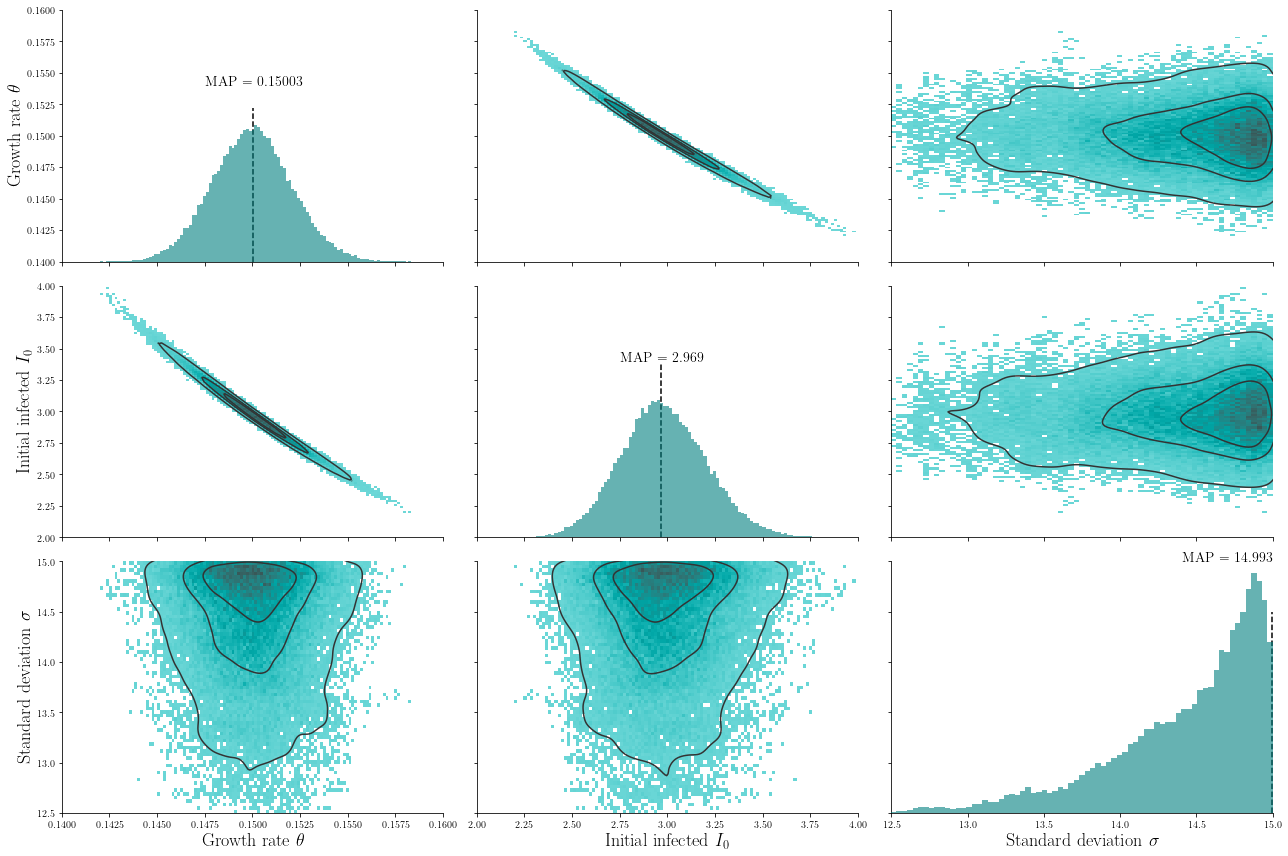

In [36]:
# plotting

fig = plt.figure(figsize=(12,10))
g = sns.pairplot(data=pd.DataFrame(data=dist), kind="hist", height=4, aspect=1.5,
                 plot_kws= {'color': 'teal'}, diag_kws={'color': 'teal', 'alpha': 0.6,
                                                       'linewidth': 0})
g.map_lower(sns.kdeplot, levels=4, color=".2")
g.map_upper(sns.kdeplot, levels=4, color=".2")
g.axes[0,0].set_ylabel(r'Growth rate $\theta$', fontsize = 18)
g.axes[0,0].vlines(s_max[0], 0.14, 0.1522, linestyles = 'dashed', color = 'black')
g.axes[0,0].text(s_max[0], 0.154, f'MAP = {s_max[0]:.5f}', fontsize = 14, ha = 'center')
g.axes[0,0].set_ylim(0.14, 0.16)
g.axes[1,0].set_ylabel('Initial infected $I_0$', fontsize = 18)
g.axes[1,1].vlines(s_max[1], 2, 3.38, linestyles = 'dashed', color = 'black')
g.axes[1,1].text(s_max[1], 3.4, f'MAP = {s_max[1]:.3f}', fontsize = 14, ha = 'center')
g.axes[1,0].set_ylim(2, 4)
g.axes[2,0].set_ylabel('Standard deviation $\sigma$', fontsize = 18)
g.axes[2,0].set_xlabel(r'Growth rate $\theta$', fontsize = 18)
g.axes[2,0].set_xlim(0.14, 0.16)
g.axes[2,0].set_ylim(12.5, 15)
g.axes[2,1].set_xlim(2, 4)
g.axes[2,1].set_xlabel('Initial infected $I_0$', fontsize = 18)
g.axes[2,2].set_xlim(12.5, 15)
g.axes[2,2].vlines(s_max[2], 12.5, 14.5, linestyles = 'dashed', color = 'black')
g.axes[2,2].text(14.7, 15, f'MAP = {s_max[2]:.3f}', fontsize = 14, ha = 'center')
g.axes[2,2].set_xlabel('Standard deviation $\sigma$', fontsize = 18)

plt.tight_layout()
fig.patch.set_alpha(0)
for ax in fig.axes:
    ax.patch.set_alpha(0)
plt.savefig('pairplot_2.png', dpi = 300, bbox_inches = 'tight')

$I_{0}$ and $\theta$ appear to be strongly correlated. We can confirm that by looking at the spearman correlation:

In [27]:
spearmanr(*dist[:,:2].T)

SpearmanrResult(correlation=-0.9937299264956138, pvalue=0.0)

And the correlation with $\sigma$ is still small:

In [33]:
print(f"Correlation between I0 and sigma: {spearmanr(*dist[:,[1,2]].T)}")
print(f"Correlation between theta and sigma: {spearmanr(*dist[:,[0,2]].T)}")

Correlation between I0 and sigma: SpearmanrResult(correlation=0.05519353843253511, pvalue=4.832975988928112e-35)
Correlation between theta and sigma: SpearmanrResult(correlation=-0.054177333300368155, pvalue=7.988225978835929e-34)


With the results, we can look at how this posterior distribution corresponds to different possible data generated from this model.

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 211.23it/s]


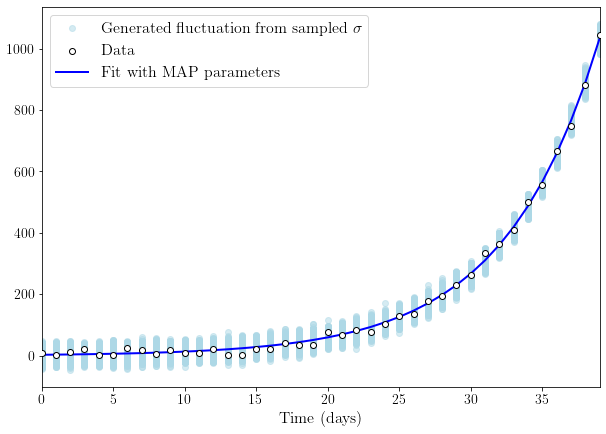

In [34]:
plt.figure(figsize=(10,7))

for i in tqdm(range(len(dist)-1000, len(dist))):
    if i == len(dist)-1:
        plt.scatter(t, exp_func2(t, dist[i,1], dist[i,0])+np.random.normal(0, dist[i,2], size=len(t)), c="lightblue", alpha=0.5, label="Generated fluctuation from sampled $\sigma$")
    else:
        plt.scatter(t, exp_func2(t, dist[i,1], dist[i,0])+np.random.normal(0, dist[i,2], size=len(t)), c="lightblue", alpha=0.5)
    
plt.scatter(t, I, facecolors="w", edgecolors="k", zorder=3, label="Data")
plt.plot(t, exp_func2(t, s_max[1], s_max[0]), c="b", lw=2, label="Fit with MAP parameters")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel("Time (days)", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0, 39)

# plt.show()
plt.savefig("fit_I0_theta.png", dpi=300, bbox_inches="tight")